In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
from geopy.distance import geodesic

In [3]:
# Download the street network of Aalborg
def download_street_network():
    return ox.graph_from_place('Aalborg Municipality, Denmark', network_type='drive', simplify=True, retain_all=False)

# Function to calculate the closest distance from a node to a POI (handles points and polygons)
def calculate_closest_poi_distance(node, pois, G):
    node_point = (G.nodes[node]['y'], G.nodes[node]['x'])  # Node's lat/lon
    closest_distance = np.inf
    for poi in pois.itertuples():
        if poi.geometry.geom_type == 'Point':  # If it's a point
            poi_point = (poi.geometry.y, poi.geometry.x)
        elif poi.geometry.geom_type == 'Polygon':  # If it's a polygon
            poi_point = (poi.geometry.centroid.y, poi.geometry.centroid.x)  # Use the centroid
        else:
            continue  # Skip if not a valid geometry type
        
        distance = geodesic(node_point, poi_point).meters
        if distance < closest_distance:
            closest_distance = distance
    return closest_distance

# Function to add edge attributes
def add_edge_attributes(G):
    for u, v, k, data in G.edges(keys=True, data=True):
        # Add speed limit (maxspeed)
        maxspeed = data.get('maxspeed', 'None')
        if isinstance(maxspeed, list):
            maxspeed = maxspeed[0]
        data['allowed_speed'] = maxspeed
        
        # Add number of lanes
        lanes = data.get('lanes', 'None')
        data['lanes'] = lanes
        
        # Add surface type
        surface = data.get('surface', 'None')
        data['surface_type'] = surface
        
        # Add bridge and tunnel information
        data['is_bridge'] = data.get('bridge', 'False') == 'True'
        data['is_tunnel'] = data.get('tunnel', 'False') == 'True'
        
        # Add oneway information
        data['is_oneway'] = data.get('oneway', False)
        
        # Add access restriction
        data['access_restriction'] = data.get('access', 'None')

# Function to add node attributes
def add_node_attributes(G):
    for node, data in G.nodes(data=True):
        # Add crossing type and traffic signal presence
        data['crossing_type'] = data.get('crossing', 'None')
        data['traffic_signal'] = 'highway' in data and data['highway'] == 'traffic_signals'
        
        # Categorize intersection types based on degree
        degree = len(list(G.neighbors(node)))
        if degree == 3:
            data['intersection_type'] = 'T-junction'
        elif degree == 4:
            data['intersection_type'] = 'Crossroad'
        else:
            data['intersection_type'] = 'Other'

# Function to add proximity data for schools, hospitals, and parks
def add_proximity_data(G):
    schools = ox.features_from_place('Aalborg Municipality, Denmark', tags={'amenity': 'school'})
    hospitals = ox.features_from_place('Aalborg Municipality, Denmark', tags={'amenity': 'hospital'})
    parks = ox.features_from_place('Aalborg Municipality, Denmark', tags={'leisure': 'park'})
    
    for node, data in G.nodes(data=True):
        # Calculate proximity to schools
        if len(schools) > 0:
            data['proximity_to_school'] = calculate_closest_poi_distance(node, schools, G)
        else:
            data['proximity_to_school'] = np.inf
        
        # Calculate proximity to hospitals
        if len(hospitals) > 0:
            data['proximity_to_hospital'] = calculate_closest_poi_distance(node, hospitals, G)
        else:
            data['proximity_to_hospital'] = np.inf
        
        # Calculate proximity to parks
        if len(parks) > 0:
            data['proximity_to_park'] = calculate_closest_poi_distance(node, parks, G)
        else:
            data['proximity_to_park'] = np.inf

# Function to add crossing data to nodes
def add_crossing_data(G):
    crossings = ox.features_from_place('Aalborg Municipality, Denmark', tags={'highway': 'crossing'})
    
    for node, data in G.nodes(data=True):
        # Find crossing information
        for poi in crossings.itertuples():
            if G.nodes[node]['y'] == poi.geometry.y and G.nodes[node]['x'] == poi.geometry.x:
                data['crossing'] = 'yes'
                data['crossing_type'] = poi.crossing if 'crossing' in poi._fields else 'unknown'
                data['crossing_ref'] = poi.crossing_ref if 'crossing_ref' in poi._fields else 'unknown'
                data['traffic_signals'] = poi.traffic_signals if 'traffic_signals' in poi._fields else 'unknown'
                data['tactile_paving'] = poi.tactile_paving if 'tactile_paving' in poi._fields else 'unknown'
                data['kerb'] = poi.kerb if 'kerb' in poi._fields else 'unknown'

# Function to calculate centrality measures
def add_centrality_measures(G):
    centrality = nx.betweenness_centrality(G, normalized=True, endpoints=True)
    closeness = nx.closeness_centrality(G)
    
    for node, data in G.nodes(data=True):
        data['betweenness_centrality'] = centrality[node]
        data['closeness_centrality'] = closeness[node]

# Main function to run all the above functions

G = download_street_network()

add_edge_attributes(G)
add_node_attributes(G)
add_proximity_data(G)
add_crossing_data(G)
add_centrality_measures(G)

# Example: Print proximity of the first node to school, hospital, and park
for node, data in G.nodes(data=True):
    print(f"Node {node} has proximity to school: {data['proximity_to_school']} meters")
    print(f"Node {node} has proximity to hospital: {data['proximity_to_hospital']} meters")
    print(f"Node {node} has proximity to park: {data['proximity_to_park']} meters")
    print(f"Betweenness Centrality: {data['betweenness_centrality']}")
    print(f"Closeness Centrality: {data['closeness_centrality']}")
    break  # Remove to check more nodes



KeyboardInterrupt: 

In [ ]:

ox.save_graphml(G, filepath='aalborg_network.graphml')


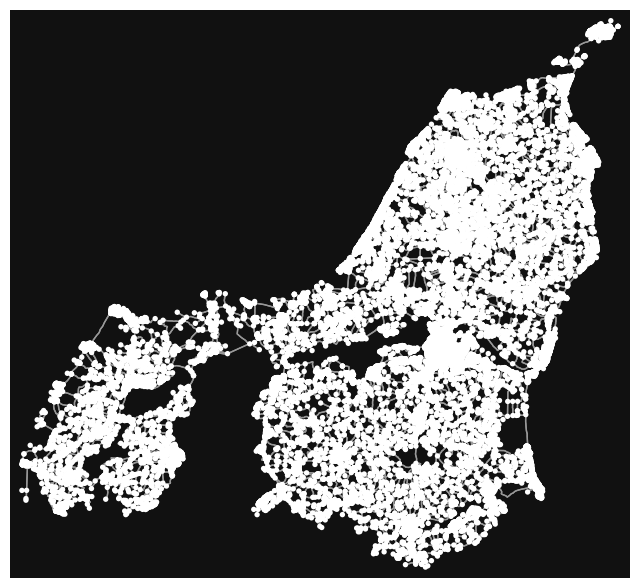

In [2]:
# import osmnx as ox

# # Download street network for Region Nordjylland
# G = ox.graph_from_place('Region Nordjylland, Denmark', network_type='drive', simplify=True, retain_all=False)

# # Plot or analyze the graph
# ox.plot_graph(G)

# # Save graph to disk
# ox.save_graphml(G, filepath='nordjylland.graphml')

In [3]:

ox.save_graphml(G, filepath='aalborg_network.graphml')


In [4]:
# # load geopackage 
# import osmnx as ox
# import networkx as nx
# import pandas as pd
# import geopandas as gpd

# # Load the graph from the GeoPackage file
# G = ox.load_graphml('aalborg_network.graphml')

In [36]:
graph_aa =  ox.graph_from_place('Aalborg Municipality, Denmark', network_type='drive', simplify=False, retain_all=False)

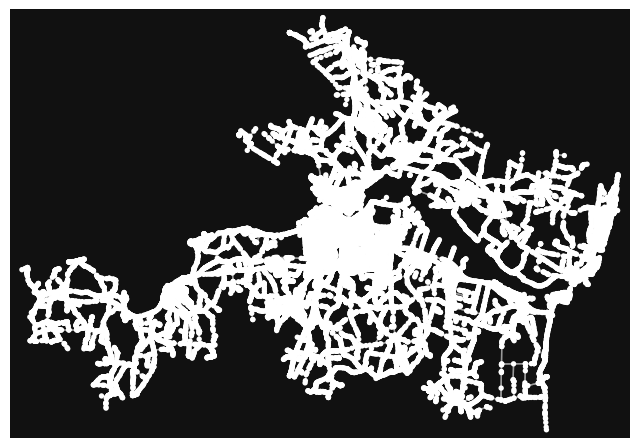

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
ox.plot_graph(graph_aa)

In [ ]:
# plot interactive graph
ox.graph_to_gdfs(graph_aa, nodes=False).explore()


In [31]:
mastra_long = pd.read_csv('mastra_long.csv')

# Create a dictionary to store the DataFrames with unique key identifiers
grouped_dataframes = {}

# Group by the specified columns
for key, group in mastra_long.groupby(["Vej-Id", "Xkoordinat", "Ykoordinat"]):
    # Use the unique key for naming or accessing each DataFrame
    sorted_group = group.sort_values(by=['Vej-Id', 'Dato', 'time_start'])
    grouped_dataframes[key] = sorted_group.reset_index(drop=True,inplace=False).set_index('datetime', inplace=False)

In [51]:

# Project graph and extract nodes and edges
graph_aa_proj = ox.project_graph(graph_aa)
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_aa_proj, nodes=True, edges=True)

# Function to calculate Euclidean distance between two points
def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

# Initialize progress tracking
total_dataframes = len(grouped_dataframes)
start_time = time.time()
x = 5  # Print status every x DataFrames processed
distance_threshold = 1000  # Only assign if node is within this distance

# Ensure 'time_series_data' column in nodes_proj can store complex data
nodes_proj['time_series_data'] = pd.Series([None] * len(nodes_proj), dtype="object")

# Iterate over each grouped DataFrame in `grouped_dataframes`
for df_index, (key, df) in enumerate(grouped_dataframes.items(), start=1):
    vej_id, df_x, df_y = key
    data_point = Point(df_x, df_y)

    # Ensure index is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index, errors='coerce')

    # List to store nodes and distances
    node_distances = []

    # Loop over all nodes in `nodes_proj` and calculate distances
    for node_index, node_data in nodes_proj.iterrows():
        node_x, node_y = node_data['x'], node_data['y']
        
        # Calculate distance from node to DataFrame's x, y
        distance = euclidean_distance(node_x, node_y, df_x, df_y)
        
        # Track each node with its distance, if within the threshold
        if distance <= distance_threshold:
            node_distances.append((node_index, distance))

    # Sort nodes by distance in ascending order
    node_distances.sort(key=lambda x: x[1])

    # Try to assign data to the closest unoccupied node within the threshold
    assigned = False
    for node_index, distance in node_distances:
        # Check if the node's `time_series_data` is empty
        time_series_content = nodes_proj.at[node_index, 'time_series_data']
        if isinstance(time_series_content, float):
            if pd.isna(time_series_content):
                time_series_data = list(zip(df.index, df['traffic_flow'].tolist()))
                nodes_proj.at[node_index, 'time_series_data'] = time_series_data
                graph_aa_proj.nodes[node_index]['time_series_data'] = time_series_data
                print(f"Assigned data to node {node_index} for DataFrame {df_index}/{total_dataframes}, Distance: {distance:.2f}")
                assigned = True
                break  # Stop once data is assigned
        elif time_series_content is None or (isinstance(time_series_content, list) and len(time_series_content) == 0):
            time_series_data = list(zip(df.index.to_pydatetime(), df['traffic_flow'].tolist()))
            nodes_proj.at[node_index, 'time_series_data'] = time_series_data
            graph_aa_proj[node_index[0]][node_index[1]][0]['time_series_data'] = time_series_data
            print(f"Assigned data to Node {node_index} for DataFrame {df_index}/{total_dataframes}, Distance: {distance:.2f}")
            assigned = True
            break  # Stop once data is assigned

    # If no unoccupied node is found within the threshold, log the result
    if not assigned:
        print(f"No suitable unoccupied node found within threshold for DataFrame {df_index}/{total_dataframes}")

    # Progress update every x DataFrames
    if df_index % x == 0:
        avg_time_per_df = (time.time() - start_time) / df_index
        estimated_total_time = avg_time_per_df * total_dataframes
        remaining_time = estimated_total_time - (time.time() - start_time)
        print(f"Processed {df_index}/{total_dataframes} DataFrames. Remaining time: {remaining_time / 60:.2f} minutes")

# Final summary
print("\nProcessing complete.")
print(f"Total DataFrames processed: {total_dataframes}")

# Inspect a few entries to confirm data assignment
print("\nVerification of assigned data:")
print(nodes_proj['time_series_data'].dropna().head())
print("\nNodes with no data assigned:", nodes_proj[nodes_proj['time_series_data'].isna()])

Assigned data to node 3468123906 for DataFrame 1/485, Distance: 11.29
Assigned data to node 3468577842 for DataFrame 2/485, Distance: 11.58
Assigned data to node 3468577843 for DataFrame 3/485, Distance: 35.15
Assigned data to node 1153164418 for DataFrame 4/485, Distance: 35.20
Assigned data to node 3468577841 for DataFrame 5/485, Distance: 38.91
Processed 5/485 DataFrames. Remaining time: 12.56 minutes
Assigned data to node 1153163302 for DataFrame 6/485, Distance: 39.11
Assigned data to node 3468577844 for DataFrame 7/485, Distance: 63.42
Assigned data to node 280821766 for DataFrame 8/485, Distance: 186.01
Assigned data to node 3470994053 for DataFrame 9/485, Distance: 219.80
Assigned data to node 392631840 for DataFrame 10/485, Distance: 264.99
Processed 10/485 DataFrames. Remaining time: 12.03 minutes
Assigned data to node 280821804 for DataFrame 11/485, Distance: 364.16
Assigned data to node 1368220931 for DataFrame 12/485, Distance: 365.35
Assigned data to node 1601440333 for D

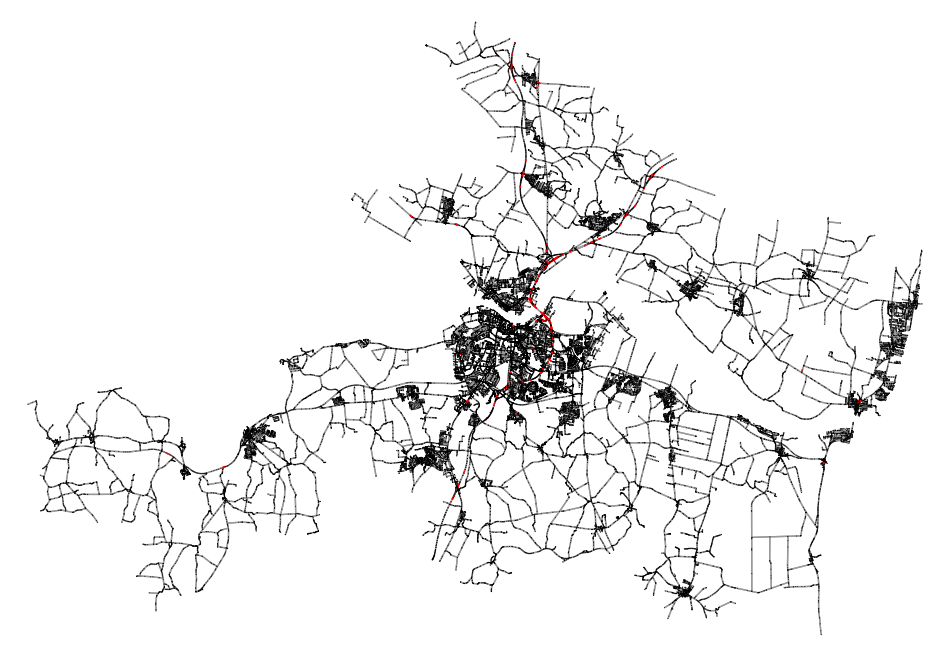

C:\Users\gonde\AppData\Local\Temp\ipykernel_19740\1192301636.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [66]:
import matplotlib.pyplot as plt

# Create a list to store the color for each edge
node_colors = ["red" if "time_series_data" in data else "black" for u, data in graph_aa_proj.nodes(data=True)]

# Set a width for each edge based on whether it has time series data or not
node_widths = [1.5 if "time_series_data" in data else 0.5 for u, data in graph_aa_proj.nodes(data=True)]

# Plot the graph with osmnx
fig, ax = ox.plot_graph(
    graph_aa_proj,
    node_color=edge_colors,
    node_size=edge_widths,
    figsize=(12, 12),
    bgcolor="white"  # Optional: set a background color
)
ax.set_title("Street Network with Edges Containing Time Series Data Highlighted in Red", fontsize=15)
fig.show()

In [67]:
ox.save_graphml(graph_aa_proj, filepath='aalborg_proj_all_nodes.graphml')

In [ ]:
g_proj = ox.load_graphml('aalborg_proj_all_nodes.graphml')


In [4]:

def filter_graph_within_hops(graph, data_attr='time_series_data', hop_count=20, data_on='edges'):
    """
    Filters a graph to retain only nodes and edges within a specified number of hops from elements with specified data.
    
    Parameters:
        graph (networkx.MultiGraph): The input graph.
        data_attr (str): The attribute name to look for time series data (default is 'time_series_data').
        hop_count (int): The number of hops from each node or edge containing data to retain (default is 6).
        data_on (str): Specify 'nodes' if data is on nodes, or 'edges' if data is on edges (default is 'edges').

    Returns:
        networkx.MultiGraph: The filtered subgraph.
    """
    
    # Identify elements with the specified data attribute
    if data_on == 'edges':
        elements_with_data = [
            (u, v, key) for u, v, key, data in graph.edges(keys=True, data=True)
            if data_attr in data and data[data_attr]
        ]
    elif data_on == 'nodes':
        elements_with_data = [
            node for node, data in graph.nodes(data=True)
            if data_attr in data and data[data_attr]
        ]
    else:
        raise ValueError("Invalid value for 'data_on'. Use 'nodes' or 'edges'.")

    # Use BFS to find nodes within the specified hop count
    elements_to_keep = set()
    if data_on == 'edges':
        for u, v, key in elements_with_data:
            # Find nodes within the hop count from both ends of the edge
            nodes_within_hops = set(nx.single_source_shortest_path_length(graph, u, cutoff=hop_count).keys())
            nodes_within_hops.update(nx.single_source_shortest_path_length(graph, v, cutoff=hop_count).keys())
            
            # Add edges connected to these nodes within the graph
            for node in nodes_within_hops:
                for neighbor in graph.neighbors(node):
                    for k in graph[node][neighbor]:  # Include all multiedges
                        elements_to_keep.add((node, neighbor, k))
                        
    elif data_on == 'nodes':
        for node in elements_with_data:
            # Find all nodes within the specified hop count
            nodes_within_hops = nx.single_source_shortest_path_length(graph, node, cutoff=hop_count).keys()
            
            # Add edges connected to these nodes
            for node_within_hop in nodes_within_hops:
                for neighbor in graph.neighbors(node_within_hop):
                    for k in graph[node_within_hop][neighbor]:  # Include all multiedges
                        elements_to_keep.add((node_within_hop, neighbor, k))

    # Create a subgraph with only the elements within the specified hops
    graph_filtered = graph.edge_subgraph(elements_to_keep).copy()

    # Convert to nodes and edges GeoDataFrames for further analysis if needed
    # nodes_filtered, edges_filtered = ox.graph_to_gdfs(graph_filtered, nodes=True, edges=True)

    # Display filtered graph summary
    print(f"Filtered graph contains {graph_filtered.number_of_nodes()} nodes and {graph_filtered.number_of_edges()} edges.")
    
    return graph_filtered #, nodes_filtered, edges_filtered


In [ ]:
filtered_graph_50 = filter_graph_within_hops(g_proj, hop_count=50, data_on='nodes')


Filtered graph contains 9055 nodes and 14457 edges.


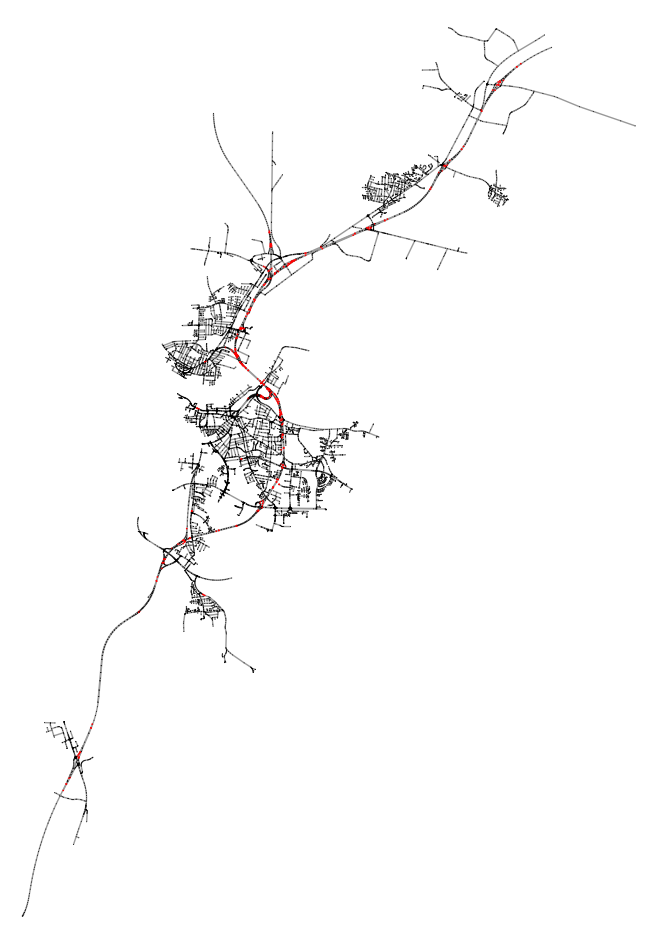

C:\Users\gonde\AppData\Local\Temp\ipykernel_8624\2796124718.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [47]:
import matplotlib.pyplot as plt
dat_graph = filtered_proj_nodes_50
# Create a list to store the color for each edge
node_colors = ["red" if "time_series_data" in data else "black" for u, data in dat_graph.nodes(data=True)]

# Set a width for each edge based on whether it has time series data or not
node_widths = [1.5 if "time_series_data" in data else 0.5 for u, data in dat_graph.nodes(data=True)]

# Plot the graph with osmnx
fig, ax = ox.plot_graph(
    dat_graph,
    node_color=node_colors,
    node_size=node_widths,
    figsize=(12, 12),
    bgcolor="white"  # Optional: set a background color
)
ax.set_title("Street Network with Edges Containing Time Series Data Highlighted in Red", fontsize=15)
fig.show()

In [49]:
fig.savefig('aalborg_nodes_undirected_filtered_50.png')

In [41]:
undirected_proj_filtered_50 = filtered_graph_50.to_undirected()
# find biggest connected component and save the graph
largest_cc = max(nx.connected_components(undirected_proj_filtered_50), key=len)
filtered_proj_nodes_50 = undirected_proj_filtered_50.subgraph(largest_cc).copy()

In [42]:
ox.save_graphml(filtered_proj_nodes_50, filepath='aalborg_undirected_filtered_50.graphml')

Total

In [15]:
total_proj = ox.load_graphml('total_proj.graphml')

In [24]:
filtered_total_graph = filter_graph_within_hops(total_proj, hop_count=7, data_on='edges')

Filtered graph contains 3933 nodes and 7551 edges.


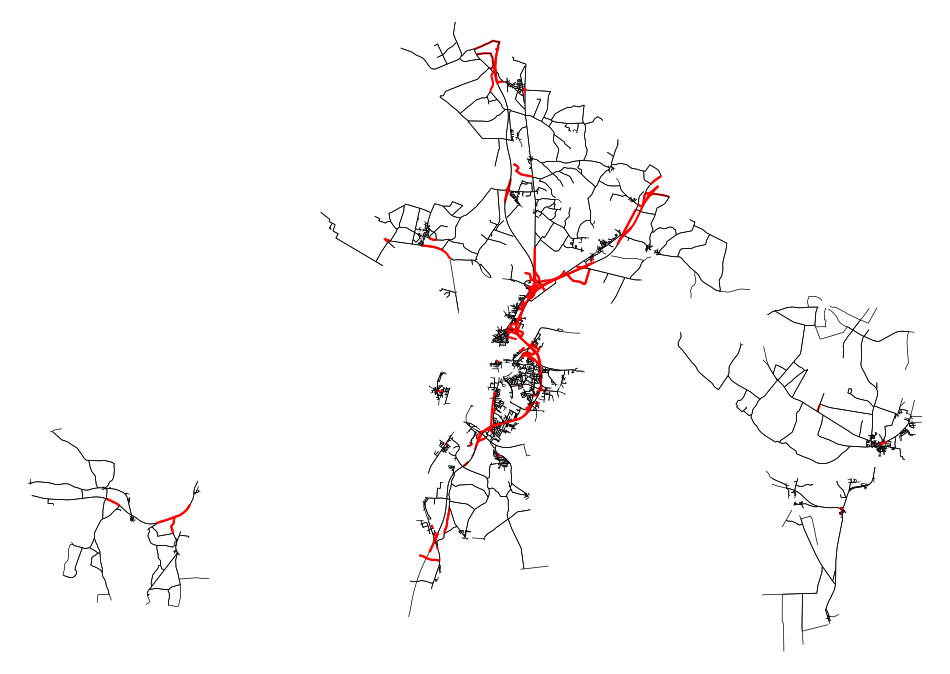

C:\Users\gonde\AppData\Local\Temp\ipykernel_8624\2862719167.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [25]:

# Create a list to store the color for each edge
edge_colors = ["red" if "time_series_data" in data else "black" for u, v, key, data in filtered_total_graph.edges(keys=True, data=True)]

# Set a width for each edge based on whether it has time series data or not
edge_widths = [1.5 if "time_series_data" in data else 0.5 for u, v, key, data in filtered_total_graph.edges(keys=True, data=True)]

# Plot the graph with osmnx
fig, ax = ox.plot_graph(
    filtered_total_graph,
    edge_color=edge_colors,
    edge_linewidth=edge_widths,
    node_size=0,  # Hide nodes if not needed
    figsize=(12, 12),
    bgcolor="white"  # Optional: set a background color
)
fig.savefig('aalborg_network_time_series.png')
# Set the plot title
ax.set_title("Street Network with Edges Containing Time Series Data Highlighted in Red", fontsize=15)
fig.show()

In [26]:
filtered_total_undirected = filtered_total_graph.to_undirected()

In [30]:
# find biggest connected component and save the graph
largest_cc = max(nx.connected_components(filtered_total_undirected), key=len)
filtered_total_cc = filtered_total_undirected.subgraph(largest_cc).copy()

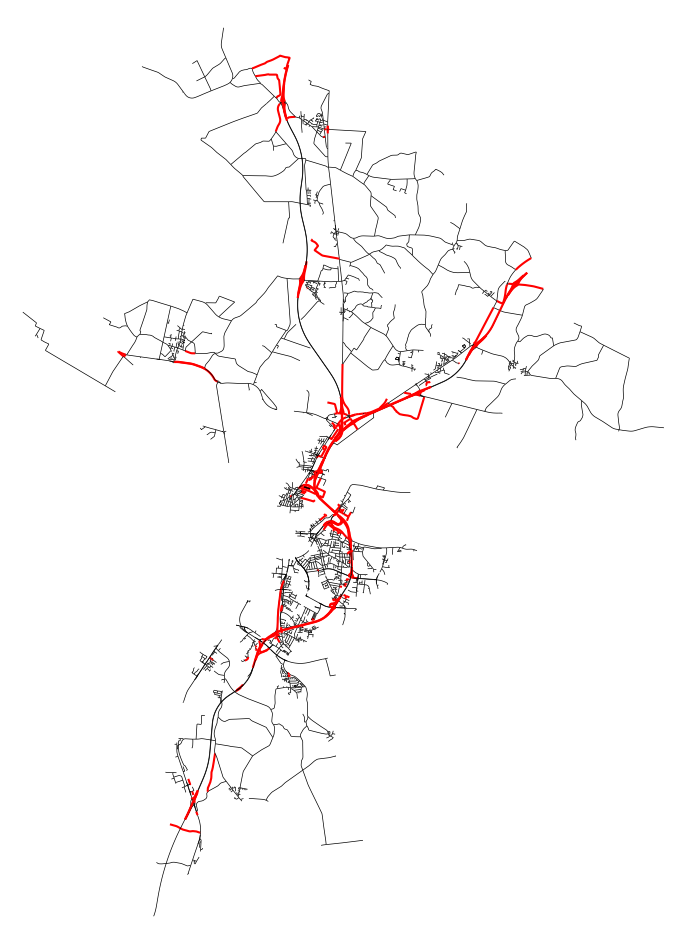

C:\Users\gonde\AppData\Local\Temp\ipykernel_8624\2126422713.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [31]:

# Create a list to store the color for each edge
edge_colors = ["red" if "time_series_data" in data else "black" for u, v, key, data in filtered_total_cc.edges(keys=True, data=True)]

# Set a width for each edge based on whether it has time series data or not
edge_widths = [1.5 if "time_series_data" in data else 0.5 for u, v, key, data in filtered_total_cc.edges(keys=True, data=True)]

# Plot the graph with osmnx
fig, ax = ox.plot_graph(
    filtered_total_cc,
    edge_color=edge_colors,
    edge_linewidth=edge_widths,
    node_size=0,  # Hide nodes if not needed
    figsize=(12, 12),
    bgcolor="white"  # Optional: set a background color
)
fig.savefig('aalborg_network_time_series.png')
# Set the plot title
ax.set_title("Street Network with Edges Containing Time Series Data Highlighted in Red", fontsize=15)
fig.show()

In [34]:
fig.savefig('aalborg_edges_undirected_7.png')

In [33]:
ox.save_graphml(filtered_total_cc, filepath='aalborg_edges_undirected_7.graphml')